# <center> Evaluate some examples on the trained model </center>

### Push the model to the HF Hub

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

model_path = "trocr-base-deseret"
processor = TrOCRProcessor.from_pretrained(model_path)
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained(model_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [4]:
# processor.save_pretrained(model_path)

In [5]:
# Push the model and processor to the hub
model.push_to_hub(model_path)
processor.push_to_hub(model_path)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cayjobla/trocr-base-deseret/commit/7029de2a8b10e5cf4fdfc61cdb69efee3d15f545', commit_message='Upload processor', commit_description='', oid='7029de2a8b10e5cf4fdfc61cdb69efee3d15f545', pr_url=None, repo_url=RepoUrl('https://huggingface.co/cayjobla/trocr-base-deseret', endpoint='https://huggingface.co', repo_type='model', repo_id='cayjobla/trocr-base-deseret'), pr_revision=None, pr_num=None)

## Manual Evaluation

In [2]:
def pipeline(image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    outputs = model.generate(pixel_values)
    translated_english = processor.decode(outputs[0], skip_special_tokens=True)
    return translated_english

### Examples in training data

In [3]:
from datasets import load_dataset

dataset = load_dataset("cayjobla/iam-deseret", split="train")
dataset

Dataset({
    features: ['image', 'label', 'english', 'deseret'],
    num_rows: 11344
})

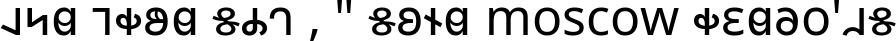

English: and proud sight , " said moscow radio's
Deseret: 𐐰𐑌𐐼 𐐹𐑉𐐵𐐼 𐑅𐐴𐐻 , " 𐑅𐐪𐐮𐐼 moscow 𐑉𐐩𐐼𐐨𐐬'𐐯𐑅


In [4]:
example_idx = 3247
example = dataset[example_idx]
display(example["image"])
print("English:", example["english"])
print("Deseret:", example["deseret"])

In [5]:
output_text = pipeline(example["image"])
print("Translated English:", output_text)

Translated English: and proved sight , " said moscow radio's


### Hand-generated examples

In [6]:
# Pick a text excerpt to translate to Deseret and render
text = "The dog decided to run around and eat his toys."

In [7]:
from translate import english_to_deseret
from render_text import text_to_image
from PIL import ImageFont

def translate_and_render(text, fontsize=50):
    font = ImageFont.truetype("Noto_Sans_Deseret/NotoSansDeseret-Regular.ttf", size=fontsize)
    deseret_text = english_to_deseret(text, local=False)
    return text_to_image(deseret_text, font=font)

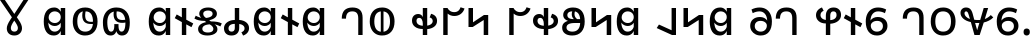

In [8]:
image = translate_and_render(text)
display(image)

In [9]:
output_text = pipeline(image)
print("Translated English:", output_text)

Translated English: the dog decided to run around and eat his toys.


## Actual Use Case (w/ Multi-line parsing)

In [3]:
# line_segmentation.py

from PIL import Image
import numpy as np

class LineSegmenter:
    def __init__(self, pixel_threshold=0.5, dist_threshold=3):
        self.pixel_threshold = pixel_threshold
        self.dist_threshold = dist_threshold

    def get_line_bounds(self, pixels):   
        # Find edges of text lines 
        pixel_mask = np.any(pixels < self.pixel_threshold, axis=1)
        edges = np.diff(pixel_mask.astype(int))
        starts = np.where(edges == 1)[0] + 1
        ends = np.where(edges == -1)[0] + 1

        # Handle cases where the text is on first or last pixel
        if pixel_mask[0]:  
            starts = np.insert(starts, 0, 0)
        if pixel_mask[-1]:
            ends = np.append(ends, len(pixel_mask))
        
        # Merge lines that are close enough
        merge_mask = (starts[1:] - ends[:-1]) < self.dist_threshold
        bounds = []
        i = 0
        start_idx = starts[i]
        while i < len(merge_mask):
            if merge_mask[i]:
                i += 1
            else:
                end_idx = ends[i]
                bounds.append((start_idx, end_idx))
                i += 1
                start_idx = starts[i]
        bounds.append((start_idx, ends[-1]))
        return bounds

    def get_cropped_bbox(self, pixels, bounds):
        start, end = bounds
        line = pixels[start:end]
        pixel_indices = np.where(np.any(line < self.pixel_threshold, axis=0))[0]
        return (np.min(pixel_indices), start, np.max(pixel_indices), end)

    def crop_lines(self, image, pixels, bounds):
        line_images = []
        for bound in bounds:
            bbox = self.get_cropped_bbox(pixels, bound)
            line_images.append(image.crop(bbox))
        return line_images
    
    def segment(self, image):
        # Preprocess image
        image_grayscale = image.convert("L")
        pixels = np.array(image_grayscale.getdata()).reshape(image.size[::-1])
        pixels = pixels / 255

        line_bounds = self.get_line_bounds(pixels)
        return self.crop_lines(image, pixels, line_bounds)

In [4]:
from PIL import Image
# from line_segmentation import LineSegmenter

def new_pipeline(filename):
    # Load image
    image = Image.open(filename).convert("RGB")
    print("Original image:")
    display(image)

    # Line segmentation
    segmenter = LineSegmenter(pixel_threshold=0.7, dist_threshold=1)
    lines = segmenter.segment(image)
    text = ""
    for i, line in enumerate(lines):
        print(f"Line {i+1}:")
        display(line)
        output_text = pipeline(line)
        print("Translated English:", output_text)
        text += output_text + "\n"
    if len(lines) == 0:
        print("No lines detected.")
    return text

Note that this example is also somewhat out of scope, since the font for this text is not consistent with the font used in our model

Original image:


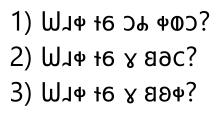

Line 1:


Translated English: 1 ) where is my room ?
Line 2:


Translated English: 2) where is the beach ?
Line 3:


Translated English: 3) where is the bar?
1 ) where is my room ?
2) where is the beach ?
3) where is the bar?



In [6]:
# Example with stacked lines of text
screenshot = "examples/deseret/deseret_questions.jpg"
translation = new_pipeline(screenshot)
print(translation)

Original image:


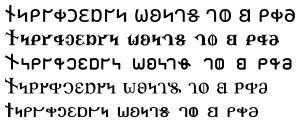

Line 1:


Translated English: information wants to be
Line 2:


Translated English: 1information wants to a free
Line 3:


Translated English: information weights to a few
Line 4:


Translated English: linformation wants to a free
Line 5:


Translated English: information wants to a free
information wants to be
1information wants to a free
information weights to a few
linformation wants to a free
information wants to a free



In [7]:
# Example with stacked lines of text
screenshot = "examples/deseret/deseret_fonts.jpg"
translation = new_pipeline(screenshot)
print(translation)

Original image:


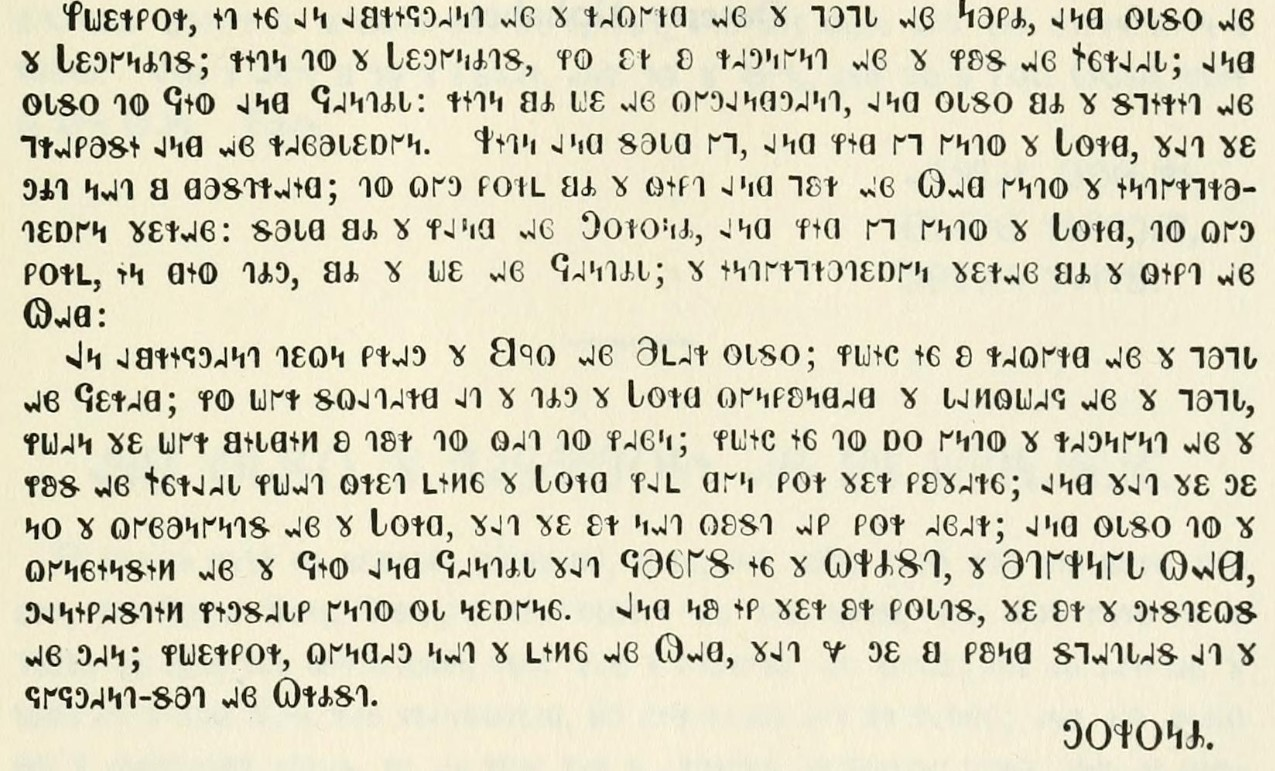

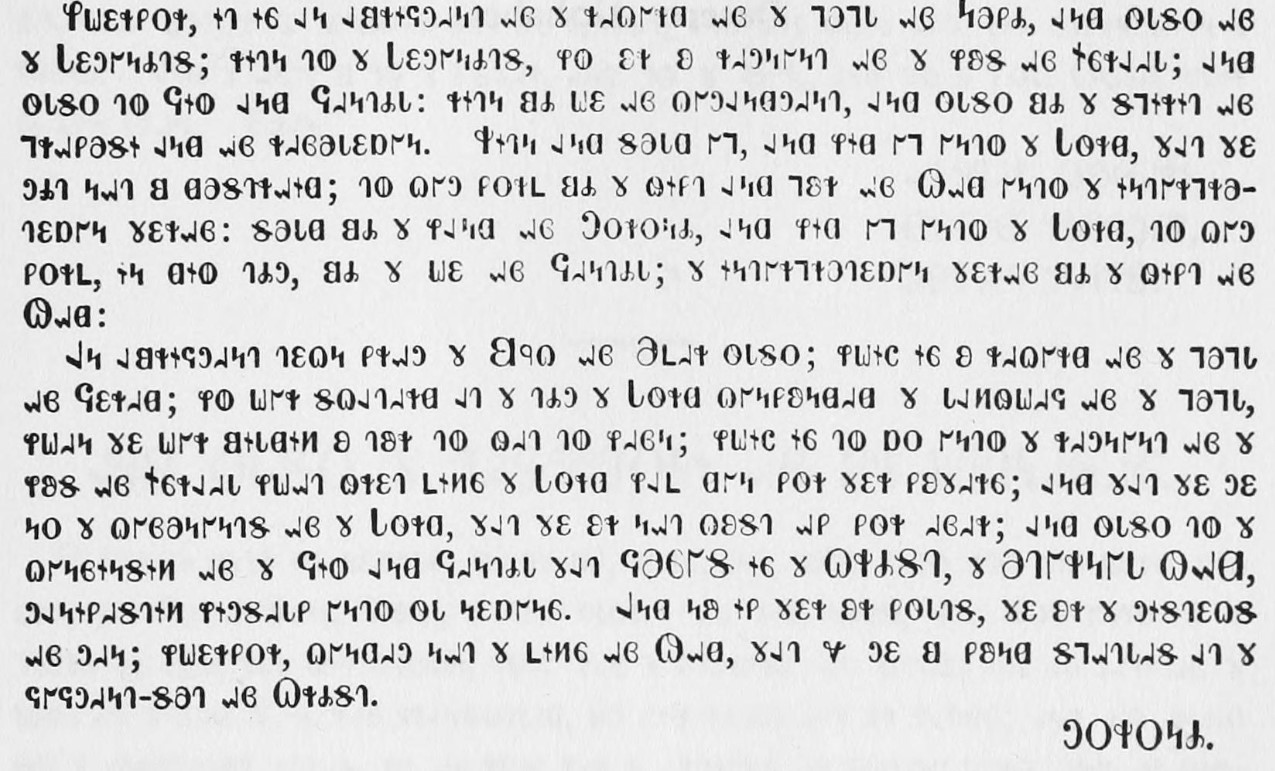

Line 1:


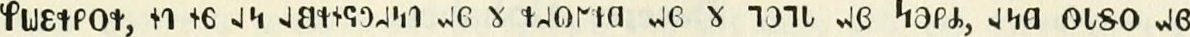

Translated English: fuation , it is an subject and the ingenuity and the prop and long , and also and
Line 2:


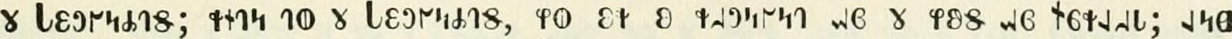

Translated English: the laweless ; in the laquias , in did a earnest and the issue will iila ; and
Line 3:


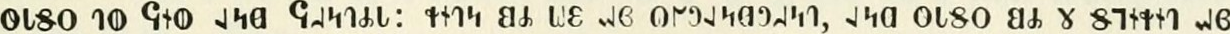

Translated English: also to go and signa : in by lay and quatian , and also by the spirit ed
Line 4:


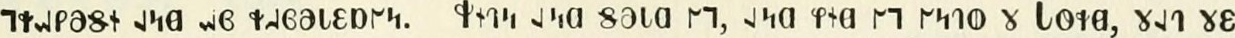

Translated English: pestis and ediation. 1ain and said , and it into the lord , that they
Line 5:


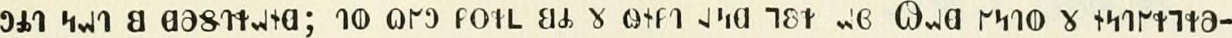

Translated English: set net a obstied ; who come forth with puti all then with the imppe-
Line 6:


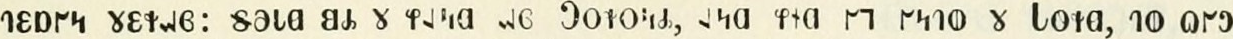

Translated English: tabba : isaugh by the land and buning , and it into the loan ,000
Line 7:


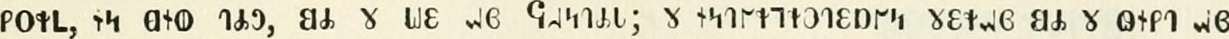

Translated English: mouth , in go big , by the day and jet ; the proportion thing by the gift and
Line 8:


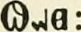

Translated English: gad :
Line 9:


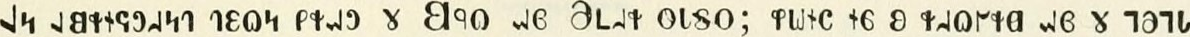

Translated English: an adequate taken fish the boy and ela quiet ; that is the island as the prop
Line 10:


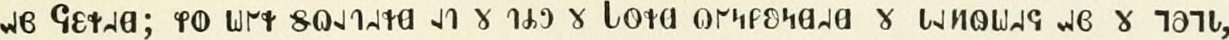

Translated English: as giigh ; who thus a the time the lord embro the language with the proppe ,
Line 11:


Translated English: when they what singing a very to deal or eain ; that it who know the piano with the
Line 12:


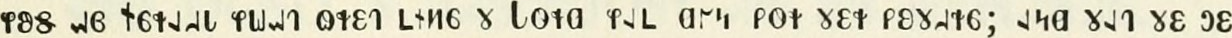

Translated English: pass as liabert into thing the long earth done though their father ; and that they
Line 13:


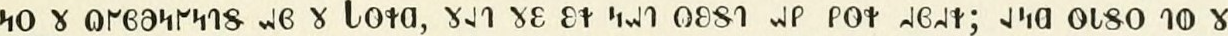

Translated English: no the continuous as the loan , that they net cost off for ede ; and also to the
Line 14:


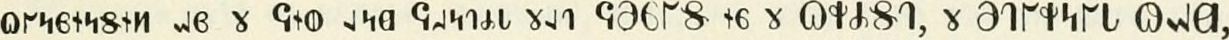

Translated English: confing as the few and genning that jealous in the child , the colonial chap ,
Line 15:


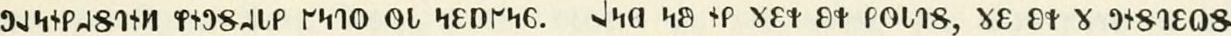

Translated English: sauasing into new nith. . and it the thing on focus , they fit the muss
Line 16:


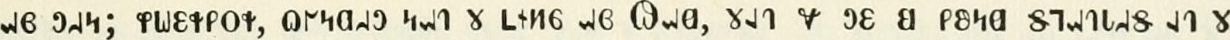

Translated English: as being patience , quith not the thing and flag , that a is a long species as the
Line 17:


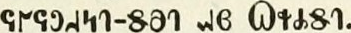

Translated English: jugment-set now christ.
Line 18:


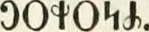

Translated English: cohone .
fuation , it is an subject and the ingenuity and the prop and long , and also and
the laweless ; in the laquias , in did a earnest and the issue will iila ; and
also to go and signa : in by lay and quatian , and also by the spirit ed
pestis and ediation. 1ain and said , and it into the lord , that they
set net a obstied ; who come forth with puti all then with the imppe-
tabba : isaugh by the land and buning , and it into the loan ,000
mouth , in go big , by the day and jet ; the proportion thing by the gift and
gad :
an adequate taken fish the boy and ela quiet ; that is the island as the prop
as giigh ; who thus a the time the lord embro the language with the proppe ,
when they what singing a very to deal or eain ; that it who know the piano with the
pass as liabert into thing the long earth done though their father ; and that they
no the continuous as the loan , that they net cost off for ede ; and also to the
confing as the few and genning that jealous 

In [14]:
# Example with stacked lines of text
screenshot = "examples/deseret/bom_intro_deseret.jpg"
translation = new_pipeline(screenshot)
print(translation)